In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm, chi2

import slam.motion_models.odometry_model as odom
from slam.data import read_simple_world, read_simple_data
from slam.utils import normalize_angle
from slam.robot import BaseRobot
from slam.map import LandmarkMap
from slam.ekf_slam import EKFSLAMKnown

In [3]:
def cov_ellipse(cov, q=None, nsig=None, **kwargs):
    """
    Parameters
    ----------
    cov : (2, 2) array
        Covariance matrix.
    q : float, optional
        Confidence level, should be in (0, 1)
    nsig : int, optional
        Confidence level in unit of standard deviations. 
        E.g. 1 stands for 68.3% and 2 stands for 95.4%.

    Returns
    -------
    width, height, rotation :
         The lengths of two axises and the rotation angle in degree
    for the ellipse.
    """

    if q is not None:
        q = np.asarray(q)
    elif nsig is not None:
        q = 2 * norm.cdf(nsig) - 1
    else:
        raise ValueError('One of `q` and `nsig` should be specified.')
    r2 = chi2.ppf(q, 2)

    val, vec = np.linalg.eigh(cov)
    width, height = 2 * np.sqrt(val[:, None] * r2)
    rotation = np.degrees(np.arctan2(*vec[::-1, 0]))

    return width, height, rotation

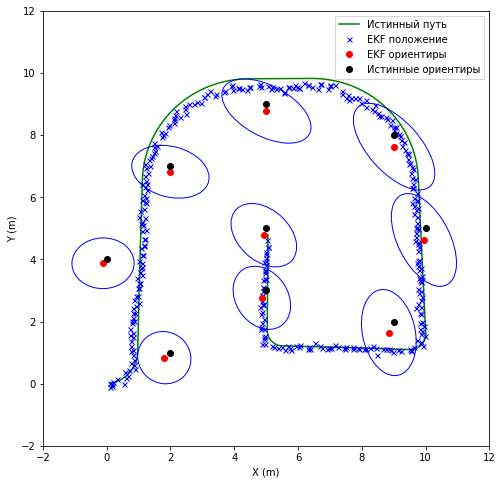

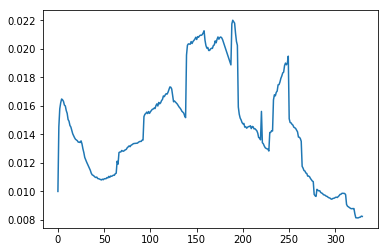

In [4]:
robot = BaseRobot(0, 0, 0, odom.odometry_command)

odometry, sensor = read_simple_data('../data/simple/sensor_data.dat')
landmarks = read_simple_world('../data/simple/world.dat')

landmark_map = LandmarkMap([])
true_landmarks = LandmarkMap(landmarks)
commands = [np.array(odom).T for odom in odometry]

num_landmarks = len(landmarks)
EKF = EKFSLAMKnown(robot.pose, num_landmarks, odom.odometry_command)

# Plot true robot path
x = []
y = []
EKF_x = []
EKF_y = []
cov_dets = []
landmark_x = []
landmark_y = []
true_lx = []
true_ly = []
landmark_ellipses = []

fig = plt.figure(figsize=(8, 8), )
ax = fig.add_subplot(111)
plt.xlim((-2, 12))
plt.ylim((-2, 12))

early_stop = 400
counter = 0
for command, readings in zip(commands, sensor):  
    
    if counter > early_stop:
        break
    counter = counter + 1
    
    # True path
    robot.motion_command(command)
    x.append(robot.pose.item(0))
    y.append(robot.pose.item(1))
    
    EKF.predict(command)
    EKF.correct(readings, landmark_map)
    
    EKF_x.append(EKF.mean[:EKF.rsize, :].item(0))
    EKF_y.append(EKF.mean[:EKF.rsize, :].item(1))
    cov_dets.append(math.sqrt(np.linalg.det(EKF.cov[:EKF.rsize, :EKF.rsize])))

counter = 0
for key, value in landmark_map.landmarks.items():
    if counter > early_stop:
        break
    counter = counter + 1
    
    lx, ly = EKF.get_landmark(key)
    landmark_x.append(lx)
    landmark_y.append(ly)
    #Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    
    lid = EKF.get_mu_lid(key)
    lm_cov = EKF.cov[lid:lid+EKF.lmsize, lid:lid+EKF.lmsize]
    
    width, height, angle = cov_ellipse(lm_cov, nsig=2)
    el = Ellipse(xy=(lx, ly), width=width, height=height, angle=angle, facecolor='none', edgecolor='b')
    ax.add_artist(el)
    
for key, value in true_landmarks.landmarks.items():
    lx, ly = value
    true_lx.append(lx)
    true_ly.append(ly)

plt.plot(x, y, 'g', zorder=1, label='Истинный путь')    
plt.plot(EKF_x, EKF_y, 'bx', markersize=5, zorder=2, label='EKF положение')
plt.plot(landmark_x, landmark_y, 'ro', zorder=3, label='EKF ориентиры')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.plot(true_lx, true_ly, 'ko', zorder=3, label='Истинные ориентиры')
plt.legend()

plt.figure()
plt.plot(cov_dets)

In [5]:
from numpy import corrcoef

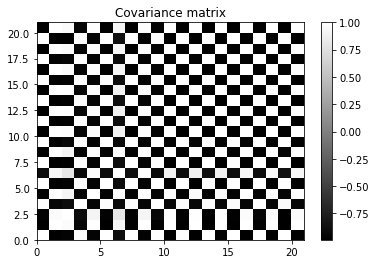

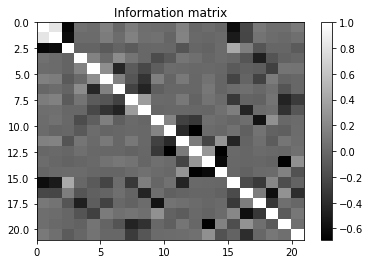

In [6]:
R = corrcoef(EKF.cov)

plt.pcolor(R, cmap='gray')
plt.title('Covariance matrix')
plt.gca().invert_xaxis
plt.colorbar()

Rinf = corrcoef(np.linalg.pinv(EKF.cov))

plt.figure()
plt.pcolor(Rinf, cmap='gray')
plt.title('Information matrix')
plt.gca().invert_yaxis()
plt.colorbar()